In [1]:
#
# Forcast elasticity from sales data
# An example of the use of a methods library in data science.
# 
# Author: George Hatem      Last Updated: 2022-10-13
#

In [2]:
import pandas as pd
import numpy as np

din = pd.read_csv("./Data/avocado.csv")
din.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
price = din.groupby("Date")[["AveragePrice"]].mean().reset_index()
price.head(10)

,Date,AveragePrice
0,2015-01-04,1.301296
1,2015-01-11,1.370648
2,2015-01-18,1.391111
3,2015-01-25,1.397130
4,2015-02-01,1.247037
5,2015-02-08,1.310463
6,2015-02-15,1.387593
7,2015-02-22,1.362685
8,2015-03-01,1.311019
9,2015-03-08,1.360093


In [4]:
volume = din.groupby("Date")[["Total Volume"]].sum().reset_index()
volume.head(10)

,Date,Total Volume
0,2015-01-04,8.467434e+07
1,2015-01-11,7.855581e+07
2,2015-01-18,7.838878e+07
3,2015-01-25,7.646628e+07
4,2015-02-01,1.194532e+08
5,2015-02-08,8.667111e+07
6,2015-02-15,7.563716e+07
7,2015-02-22,8.087609e+07
8,2015-03-01,8.943484e+07
9,2015-03-08,8.128167e+07


In [5]:
cleaned = price.join(volume.set_index("Date"), on="Date")
cleaned.head()

,Date,AveragePrice,Total Volume
0,2015-01-04,1.301296,8.467434e+07
1,2015-01-11,1.370648,7.855581e+07
2,2015-01-18,1.391111,7.838878e+07
3,2015-01-25,1.397130,7.646628e+07
4,2015-02-01,1.247037,1.194532e+08


In [6]:
# Determine current elasticity
from sklearn.linear_model import LinearRegression
pdcoef = LinearRegression().fit(cleaned[["AveragePrice"]], cleaned[["Total Volume"]]).coef_[0][0] 
cleaned["Elasticity"] = pdcoef * cleaned["AveragePrice"] / cleaned["Total Volume"]
cleaned.head()

,Date,AveragePrice,Total Volume,Elasticity
0,2015-01-04,1.301296,8.467434e+07,-0.852341
1,2015-01-11,1.370648,7.855581e+07,-0.967691
2,2015-01-18,1.391111,7.838878e+07,-0.984231
3,2015-01-25,1.397130,7.646628e+07,-1.013342
4,2015-02-01,1.247037,1.194532e+08,-0.578989


In [7]:
from datetime import datetime

date = cleaned["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").toordinal())
cleaned.set_index(pd.to_datetime(cleaned["Date"]), inplace=True)
cleaned.drop(columns=["Date"], inplace=True)

In [8]:
cleaned.head()

,AveragePrice,Total Volume,Elasticity
Date,,,
2015-01-04,1.301296,8.467434e+07,-0.852341
2015-01-11,1.370648,7.855581e+07,-0.967691
2015-01-18,1.391111,7.838878e+07,-0.984231
2015-01-25,1.397130,7.646628e+07,-1.013342
2015-02-01,1.247037,1.194532e+08,-0.578989


In [9]:
#Test of _fixDate
import re
import forecasthelper as fh
v = fh._fixDate(volume)

In [10]:
v.index.inferred_type

'datetime64'

In [11]:
#TODO: test each method

In [12]:
#TODO: Test of detrend
dem_detrended, demReg_trend, demDP = fh.detrend(volume, "Total Volume")

In [13]:
dem_detrended.head()

,Total Volume
Date,
2015-01-04,-1.241724e+06
2015-01-11,-7.430949e+06
2015-01-18,-7.668667e+06
2015-01-25,-9.661866e+06
2015-02-01,3.325439e+07


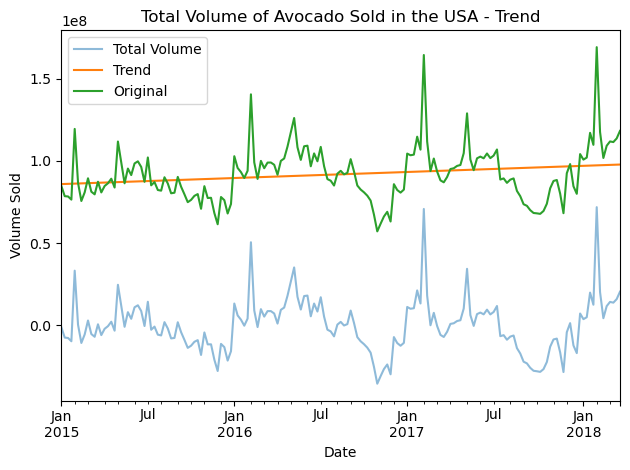

In [14]:
from matplotlib import pyplot as plt
dax = dem_detrended.plot(alpha=0.5, title="Total Volume of Avocado Sold in the USA - Trend", ylabel="Volume Sold", label="Detrended")
dax = pd.Series(demReg_trend.predict(demDP.in_sample()), index=dem_detrended.index).plot(label="Trend")
dax = cleaned["Total Volume"].plot(label="Original")
dax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.legend()
plt.show()

Text(0.5, 1.0, 'Periodogram')

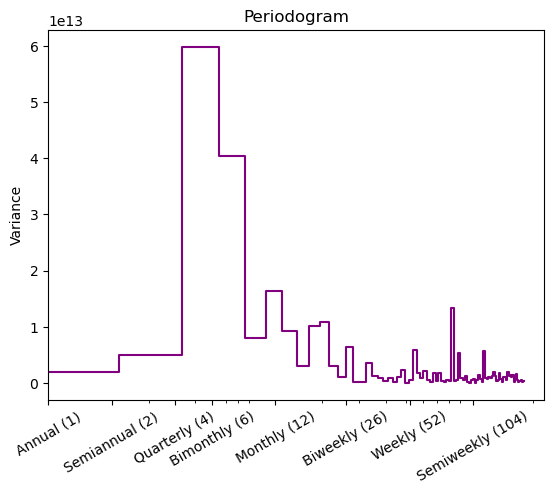

In [15]:
# Periodogram configuration as found on the Kaggle time series course
from scipy.signal import periodogram

fs = pd.Timedelta("365D") / pd.Timedelta("1D")
freqencies, spectrum = periodogram(
    dem_detrended["Total Volume"],
    fs=fs,
    detrend='linear',
    window="boxcar",
    scaling='spectrum',
)

_, ax = plt.subplots()
ax.step(freqencies, spectrum, color="purple")
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(
    [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],
    rotation=30,
)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_ylabel("Variance")
ax.set_title("Periodogram")

In [16]:
dem_deseasoned, demReg_season, demDP_season = fh.deseason(dem_detrended, ('A', 25), "Total Volume")

In [17]:
dem_deseasoned.head()

,Total Volume
Date,
2015-01-04,-5.263297e+06
2015-01-11,-5.493574e+06
2015-01-18,-2.603203e+06
2015-01-25,-1.617324e+06
2015-02-01,1.161328e+07


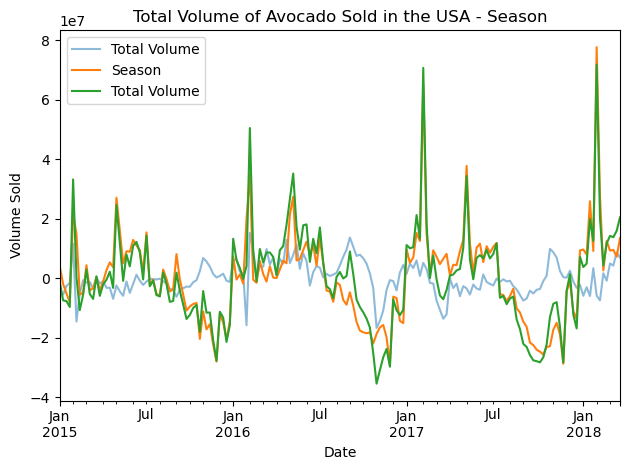

In [18]:
dsax = dem_deseasoned.plot(alpha=0.5, title="Total Volume of Avocado Sold in the USA - Season", ylabel="Volume Sold", label="Deseason & Detrended")
dsax = pd.Series(demReg_season.predict(demDP_season.in_sample()), index=dem_deseasoned.index).plot(label="Season", ax=dsax)
dsax = dem_detrended.plot(label="Detrended", ax=dsax)
dax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.legend()
plt.show()

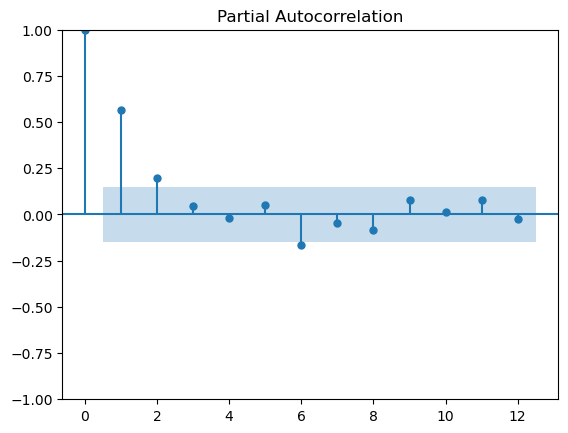

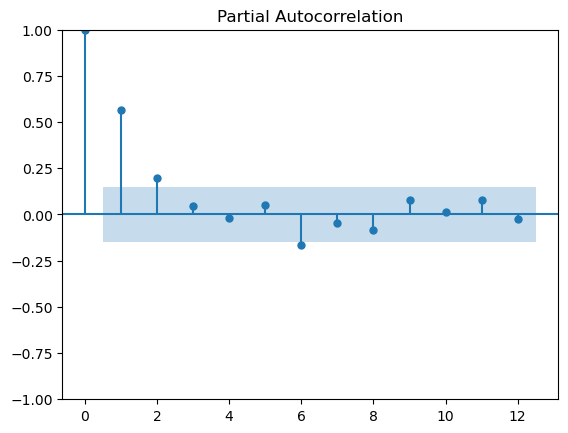

In [19]:
# Choose lag steps
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(dem_deseasoned, lags=12, method='ywm')

In [20]:
lags = fh.multi_shift(dem_deseasoned, 6, lag_steps=[1, 2, 6], target="Total Volume")

In [21]:
lags.head()

,Total Volume_lag_1,Total Volume_lag_2,Total Volume_lag_6
Date,,,
2015-01-04,NaN,NaN,NaN
2015-01-11,-5.263297e+06,NaN,NaN
2015-01-18,-5.493574e+06,-5.263297e+06,NaN
2015-01-25,-2.603203e+06,-5.493574e+06,NaN
2015-02-01,-1.617324e+06,-2.603203e+06,NaN


In [22]:
leads = fh.multi_shift(dem_deseasoned, 9, sign=False, target="Total Volume")

In [23]:
leads.head()

,Total Volume_lead_1,Total Volume_lead_2,Total Volume_lead_3,Total Volume_lead_4,Total Volume_lead_5,Total Volume_lead_6,Total Volume_lead_7,Total Volume_lead_8,Total Volume_lead_9
Date,,,,,,,,,
2015-01-04,-5.493574e+06,-2.603203e+06,-1.617324e+06,1.161328e+07,-1.455272e+07,-5.206017e+06,-6.486351e+05,-1.443053e+06,-1.249654e+06
2015-01-11,-2.603203e+06,-1.617324e+06,1.161328e+07,-1.455272e+07,-5.206017e+06,-6.486351e+05,-1.443053e+06,-1.249654e+06,-3.531829e+06
2015-01-18,-1.617324e+06,1.161328e+07,-1.455272e+07,-5.206017e+06,-6.486351e+05,-1.443053e+06,-1.249654e+06,-3.531829e+06,2.450037e+05
2015-01-25,1.161328e+07,-1.455272e+07,-5.206017e+06,-6.486351e+05,-1.443053e+06,-1.249654e+06,-3.531829e+06,2.450037e+05,-1.798949e+06
2015-02-01,-1.455272e+07,-5.206017e+06,-6.486351e+05,-1.443053e+06,-1.249654e+06,-3.531829e+06,2.450037e+05,-1.798949e+06,-9.788905e+05


In [24]:
from xgboost import XGBRegressor

demMod_residual = XGBRegressor()

c:\Users\ghy24\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [25]:
foredata, demMod_forecaster = fh.forecast(dem_deseasoned, 100, demMod_residual, target="Total Volume", lags=lags, leads=leads)

In [26]:
foredata.head()

,Total Volume_0,Total Volume_1,Total Volume_2,Total Volume_3,Total Volume_4,Total Volume_5,Total Volume_6,Total Volume_7,Total Volume_8,Total Volume_9
Date,,,,,,,,,,
2018-04-01,6975094.0,-6.556252e+05,-6.482920e+05,-6.401979e+05,-6.317512e+05,-6.401471e+05,-6.317652e+05,-5.186630e+05,-4.056063e+05,-3.811422e+05
2018-04-08,-5208736.0,-5.435416e+06,-2.603236e+06,-1.752713e+06,3.472287e+06,-9.888132e+06,-5.435086e+06,-6.925322e+05,-1.285062e+06,-1.151868e+06
2018-04-15,-5495512.0,-2.609596e+06,-1.617489e+06,1.161193e+07,-1.455259e+07,-5.205936e+06,-6.486531e+05,-1.443052e+06,-1.249637e+06,-3.531821e+06
2018-04-22,-2639259.0,-1.621787e+06,1.135209e+07,-1.455187e+07,-5.190184e+06,-6.486388e+05,-1.610752e+06,-1.249646e+06,-3.531870e+06,2.450030e+05
2018-04-29,-1611488.5,1.160821e+07,-1.455236e+07,-5.205636e+06,-6.486688e+05,-1.443048e+06,-1.249622e+06,-3.531821e+06,2.450150e+05,-1.798951e+06


In [28]:
for i in range(0, 10):
    foredata.iloc[:, i] = foredata.iloc[:, i] + demReg_trend.predict(demDP.out_of_sample(100, foredata.index)) + demReg_season.predict(demDP_season.out_of_sample(100, foredata.index))

In [29]:
foredata.head()

,Total Volume_0,Total Volume_1,Total Volume_2,Total Volume_3,Total Volume_4,Total Volume_5,Total Volume_6,Total Volume_7,Total Volume_8,Total Volume_9
Date,,,,,,,,,,
2018-04-01,1.065859e+08,9.895514e+07,9.896247e+07,9.897057e+07,9.897901e+07,9.897062e+07,9.897900e+07,9.909210e+07,9.920516e+07,9.922962e+07
2018-04-08,9.897496e+07,9.874828e+07,1.015805e+08,1.024310e+08,1.076560e+08,9.429557e+07,9.874861e+07,1.034912e+08,1.028986e+08,1.030318e+08
2018-04-15,9.572142e+07,9.860733e+07,9.959944e+07,1.128289e+08,8.666433e+07,9.601099e+07,1.005683e+08,9.977388e+07,9.996729e+07,9.768511e+07
2018-04-22,1.077815e+08,1.087990e+08,1.217729e+08,9.586891e+07,1.052306e+08,1.097721e+08,1.088100e+08,1.091711e+08,1.068889e+08,1.106658e+08
2018-04-29,1.050280e+08,1.182477e+08,9.208715e+07,1.014339e+08,1.059908e+08,1.051965e+08,1.053899e+08,1.031077e+08,1.068845e+08,1.048406e+08


In [ ]:
#TODO: replicate analysis

<AxesSubplot:xlabel='Date'>

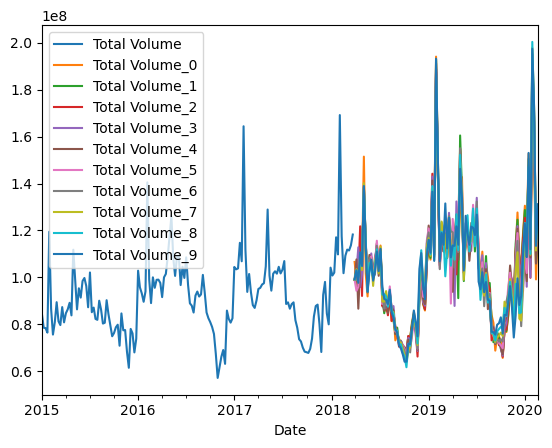

In [31]:
pd.concat([cleaned[["Total Volume"]], foredata]).plot()

<AxesSubplot:xlabel='Date'>

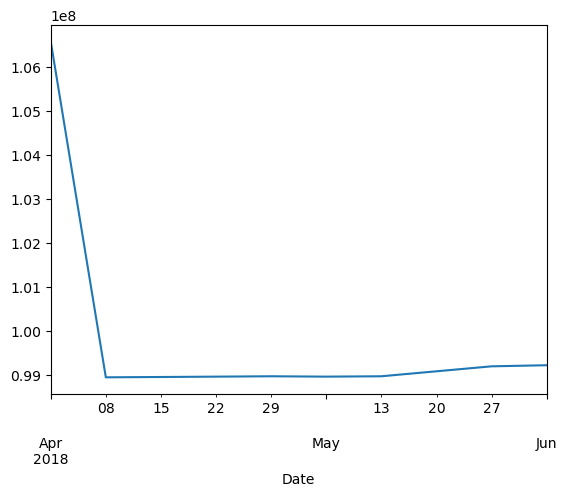

In [32]:
pd.Series(foredata.iloc[0].values,index=foredata.index[0 : 10]).plot()

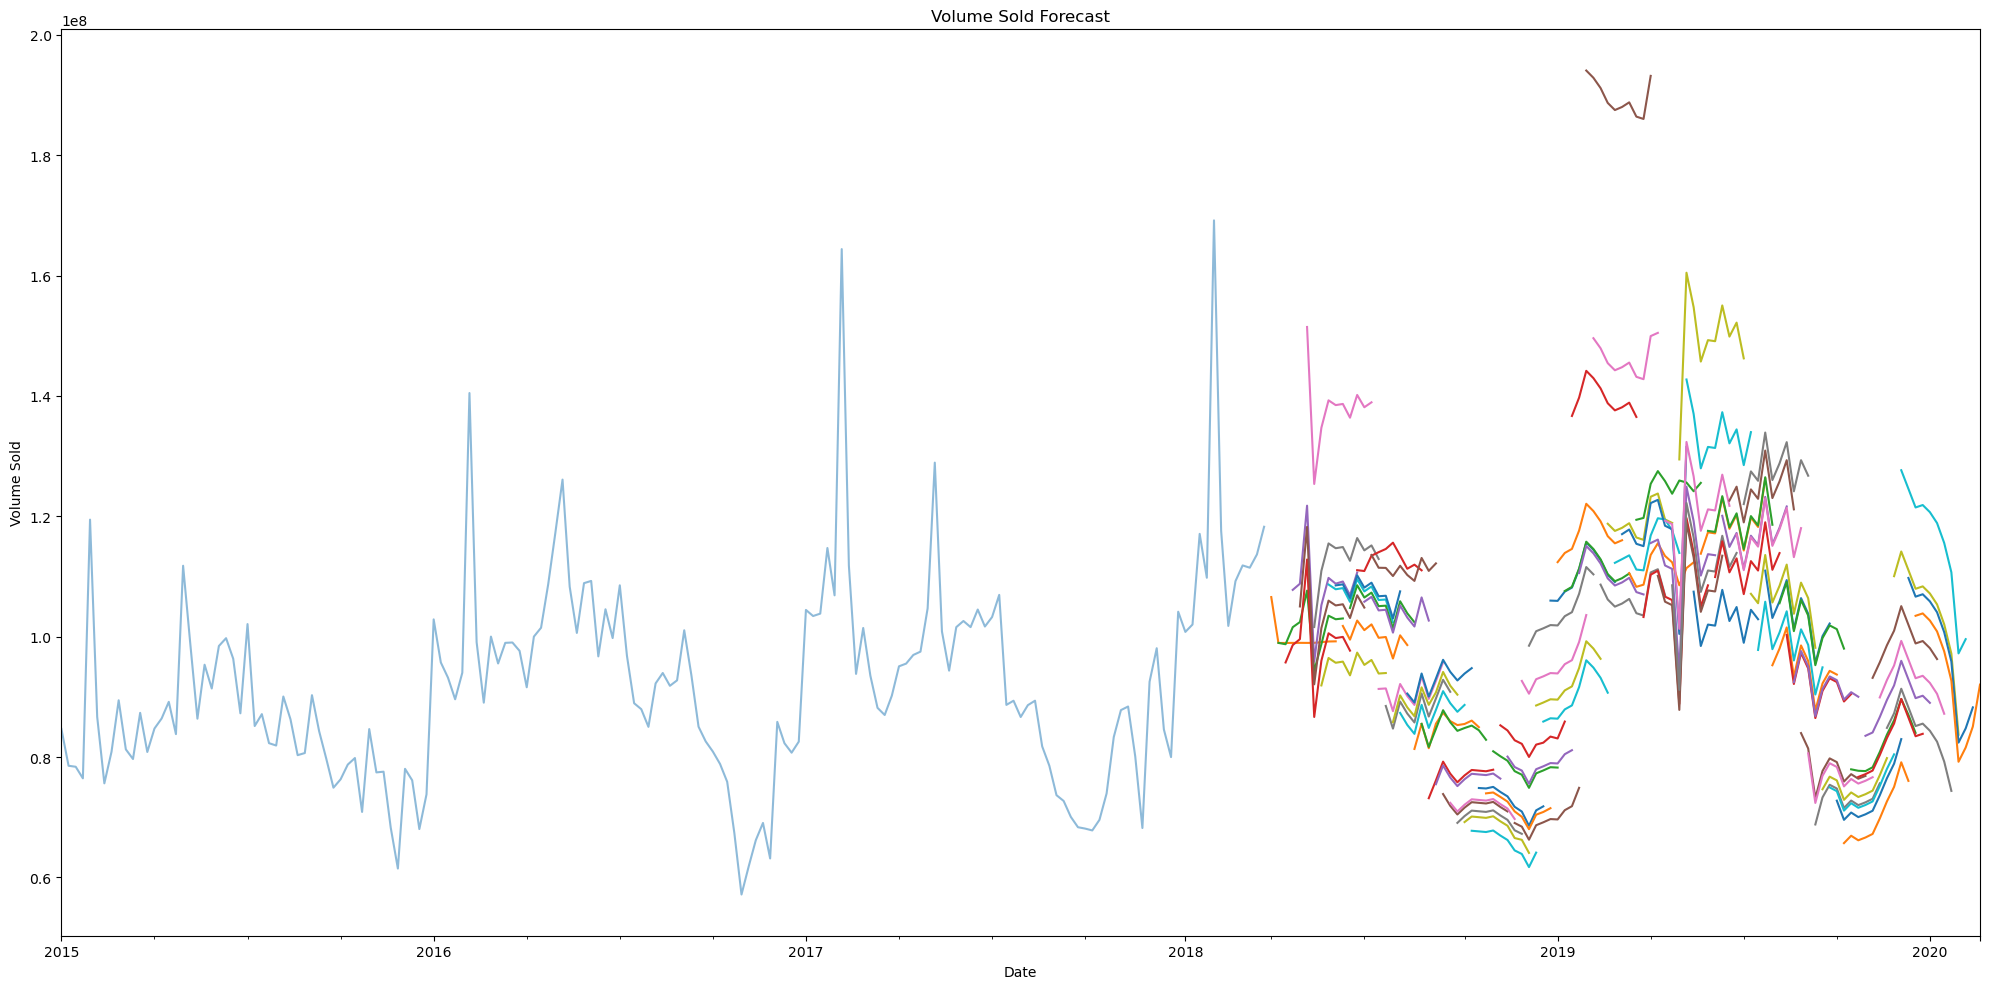

In [35]:
totalIndex = pd.concat([cleaned[["Total Volume"]], foredata]).index
p = cleaned["Total Volume"].plot(alpha=0.5, title="Volume Sold Forecast", ylabel="Volume Sold", xticks=totalIndex)
for i in range(0, 91):
    pred = foredata.iloc[i]
    pred.index=foredata.index[i : i + 10]
    p = pred.plot()
p.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()